In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import os

og_data_dir = '/home/minhang/mds_project/data/cohort_adata/'

In [2]:
augmented_adata = sc.read_h5ad(os.path.join(og_data_dir, 'adata_cellType_cnLabel_pseudoTime_collectionTime.h5ad'))

In [3]:
print(list(augmented_adata.obs['sample'].unique()))

['P01_preSCT', 'P01_Relapse', 'P01_MRD_2', 'P01_Relapse_2', 'P01_preSCT_2', 'P02_Relapse_2', 'P02_preSCT_2', 'P02_Relapse_1', 'P03_MRD_1', 'P02_MRD_1', 'P01_MRD_1', 'P02_preSCT_1', 'P02_Relapse_4', 'P02_Relapse_3', 'P03_Relapse', 'P04_Relapse', 'P04_preSCT_2', 'P04_preSCT_1', 'P05_Relapse', 'P05_preSCT', 'unknown_unknown', 'P06_preSCT_1', 'P06_preSCT_2', 'P10_preSCT', 'P07_Relapse', 'P07_preSCT_2', 'P08_preSCT_2', 'P11_preSCT', 'P08_preSCT_1', 'P08_Relapse', 'P09_preSCT_2', 'P09_preSCT_1', 'P12_preSCT', 'P09_Relapse', 'P03_MRD_2', 'P02_MRD_2', 'P05_MRD', 'P04_MRD', 'P06_MRD', 'P11_MRD', 'P07_MRD', 'P10_MRD', 'P12_MRD', 'P09_MRD', 'P08_MRD', 'P13_MRD', 'P09_MRD_2', 'P09_MRD_3', 'P09_MRD_4', 'P13_Relapse_2', 'P13_preSCT_1', 'P13_Relapse_1', 'P13_preSCT_2']


Filtered MRD cells: 70583 / 192149
Patients per Tech in MRD (unique):
Tech
CITE     ['P01', 'P03', 'P02', 'P05', 'P04', ..., 'P10'...
Multi    ['P01', 'P03', 'P02']
Categories (13, object):...
Name: patient, dtype: object


/tmp/ipykernel_1422630/446790351.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata_mrd.obs.groupby(tech_col)['patient'].unique())


Filtered to CITE: 60675 cells remain.


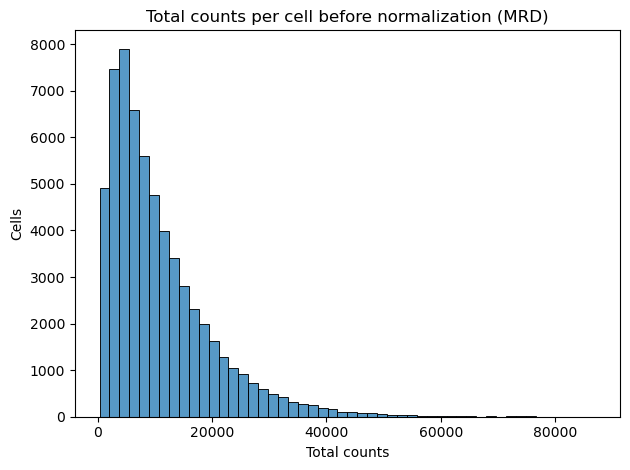

After normalization and filtering: (60675, 30743)
Running PCA...
Calculating neighborhood graph...
Running UMAP...


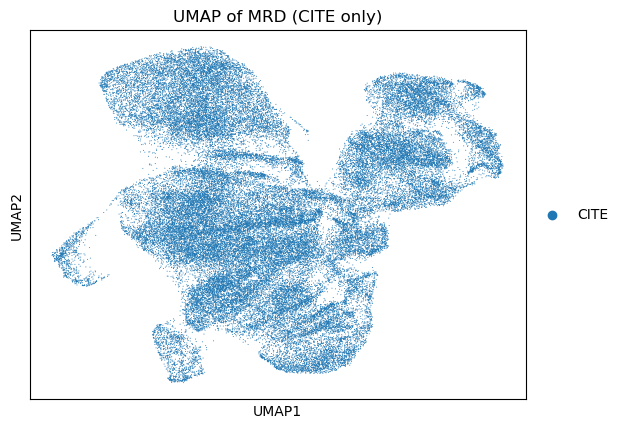

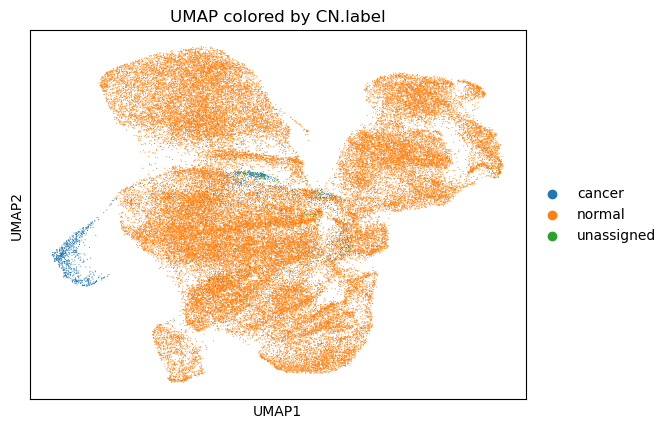

Running differential expression (Wilcoxon)...


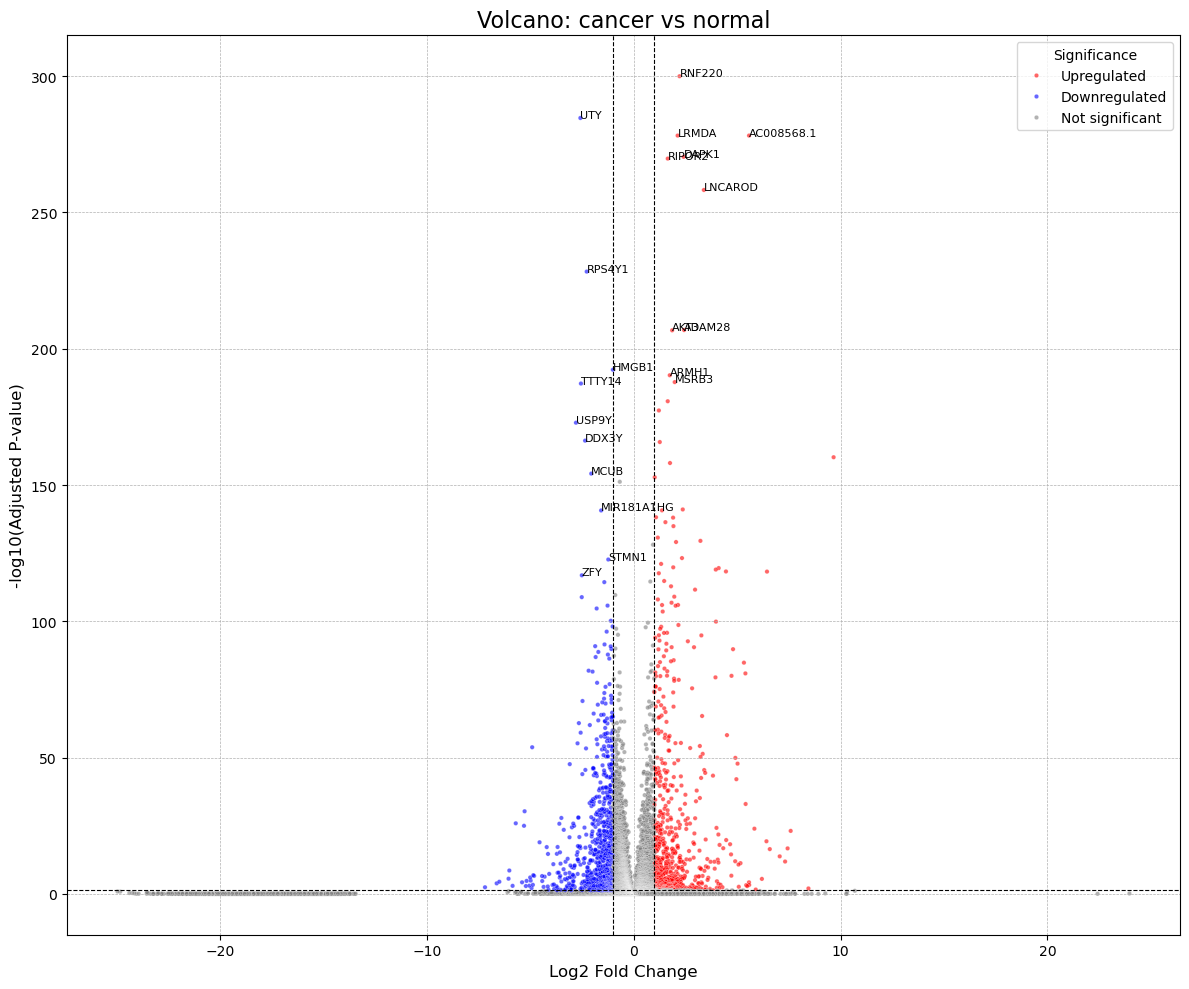

In [4]:
# MRD preprocessing pipeline (Oct 7)
import seaborn as sns
import matplotlib.pyplot as plt

try:
    from adjustText import adjust_text
except Exception:
    adjust_text = None

# 1) Filter MRD by sample substring
possible_sample_cols = ['sample', 'Sample', 'SAMPLE']
sample_col = next((c for c in possible_sample_cols if c in augmented_adata.obs.columns), None)
if sample_col is None:
    raise KeyError("Could not find a 'sample' column in augmented_adata.obs.")

is_mrd = augmented_adata.obs[sample_col].astype(str).str.contains('MRD', case=False, na=False)
adata_mrd = augmented_adata[is_mrd].copy()
print(f"Filtered MRD cells: {adata_mrd.n_obs} / {augmented_adata.n_obs}")

# 2) Filter by Tech to CITE
possible_tech_cols = ['Tech', 'tech', 'TECH']
tech_col = next((c for c in possible_tech_cols if c in adata_mrd.obs.columns), None)

if tech_col is not None:
    if 'patient' in adata_mrd.obs.columns:
        print("Patients per Tech in MRD (unique):")
        print(adata_mrd.obs.groupby(tech_col)['patient'].unique())
    else:
        print("Tech value counts in MRD:")
        print(adata_mrd.obs[tech_col].value_counts())
    is_cite = adata_mrd.obs[tech_col].astype(str).str.contains('CITE', case=False, na=False)
    adata_mrd = adata_mrd[is_cite].copy()
    print(f"Filtered to CITE: {adata_mrd.n_obs} cells remain.")
else:
    print("No 'Tech'/'tech' column found; skipping CITE filter.")

# 3) QC metrics and library size histogram
adata_mrd.layers['counts'] = adata_mrd.X.copy()
sc.pp.calculate_qc_metrics(adata_mrd, inplace=True)
try:
    sns.histplot(adata_mrd.obs['total_counts'], bins=50, kde=False)
    plt.title('Total counts per cell before normalization (MRD)')
    plt.xlabel('Total counts')
    plt.ylabel('Cells')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"QC histogram could not be plotted: {e}")

# 4) Normalize/log1p, filter genes, set .raw
sc.pp.normalize_total(adata_mrd, target_sum=1e4)
sc.pp.log1p(adata_mrd)
sc.pp.filter_genes(adata_mrd, min_cells=3)
adata_mrd.raw = adata_mrd
print(f"After normalization and filtering: {adata_mrd.shape}")

# 5) PCA / neighbors / UMAP + diagnostic plots
print("Running PCA...")
sc.tl.pca(adata_mrd, svd_solver='arpack')
print("Calculating neighborhood graph...")
sc.pp.neighbors(adata_mrd, n_pcs=min(30, adata_mrd.obsm['X_pca'].shape[1]), n_neighbors=20)
print("Running UMAP...")
sc.tl.umap(adata_mrd)

try:
    if tech_col is not None:
        sc.pl.umap(adata_mrd, color=tech_col, title='UMAP of MRD (CITE only)')
        plt.show()
    # If CN.label exists, also plot
    label_candidates = ['CN.label', 'cnLabel', 'cn_label', 'cnlabel']
    label_col = next((c for c in label_candidates if c in adata_mrd.obs.columns), None)
    if label_col is not None:
        sc.pl.umap(adata_mrd, color=label_col, title=f'UMAP colored by {label_col}')
        plt.show()
except Exception as e:
    print(f"UMAP plot could not be displayed: {e}")

# 6) DEG and volcano plot
# Prepare label column; standardize to 'CN.label'
label_candidates = ['CN.label', 'cnLabel', 'cn_label', 'cnlabel']
label_col = next((c for c in label_candidates if c in adata_mrd.obs.columns), None)
if label_col is None:
    print("No CN label column found; skipping DEG and volcano.")
else:
    # Sanity check
    label_values = adata_mrd.obs[label_col].astype(str)
    if not (('normal' in set(label_values)) and (any(v in set(label_values) for v in ['cancer','Cancer','tumor','Tumor','malignant','Malignant']))):
        print(f"Expected 'normal' and a tumor-like label in '{label_col}', found: {sorted(set(label_values))}. Skipping DEG.")
    else:
        adata_for_deg = adata_mrd.raw.to_adata()
        print("Running differential expression (Wilcoxon)...")
        sc.tl.rank_genes_groups(
            adata_for_deg,
            groupby=label_col,
            method='wilcoxon',
            reference='normal',
            key_added='rank_genes_groups'
        )
        rgs = adata_for_deg.uns['rank_genes_groups']

        # Determine tumor group name
        groups_in_res = list(rgs['names'].dtype.names) if hasattr(rgs['names'], 'dtype') and rgs['names'].dtype.names else list(adata_for_deg.obs[label_col].astype(str).unique())
        preferred_order = ['cancer','Cancer','tumor','Tumor','malignant','Malignant']
        tumor_group = next((g for g in preferred_order if g in groups_in_res), None)
        if tumor_group is None:
            tumor_group = next((g for g in groups_in_res if g.lower() != 'normal'), None)

        if tumor_group is None:
            print("Could not determine tumor group; skipping volcano plot.")
        else:
            # Build results dataframe
            def extract(arr_or_rec, group):
                # AnnData may store recarrays by column name
                return np.array(arr_or_rec[group]).ravel()
            names = extract(rgs['names'], tumor_group)
            logfc = extract(rgs['logfoldchanges'], tumor_group)
            pvals = extract(rgs['pvals'], tumor_group)
            pvals_adj = extract(rgs['pvals_adj'], tumor_group)

            results_df = pd.DataFrame({
                'names': names,
                'logfoldchanges': logfc,
                'pvals': pvals,
                'pvals_adj': pvals_adj
            })

            # Volcano
            pvals_log10 = -np.log10(np.clip(results_df['pvals_adj'].replace(0, 1e-300), 1e-300, None))
            results_df['pvals_log10'] = pvals_log10
            results_df['significant'] = 'Not significant'
            results_df.loc[(results_df['logfoldchanges'] > 1) & (results_df['pvals_adj'] < 0.05), 'significant'] = 'Upregulated'
            results_df.loc[(results_df['logfoldchanges'] < -1) & (results_df['pvals_adj'] < 0.05), 'significant'] = 'Downregulated'

            plt.figure(figsize=(12, 10))
            sns.scatterplot(
                x='logfoldchanges',
                y='pvals_log10',
                data=results_df,
                hue='significant',
                hue_order=['Upregulated', 'Downregulated', 'Not significant'],
                palette={'Upregulated': 'red', 'Downregulated': 'blue', 'Not significant': 'grey'},
                s=10, alpha=0.6
            )

            # Label top genes
            n_top_genes = 10
            top_up = results_df[results_df['significant'] == 'Upregulated'].sort_values('pvals_adj').head(n_top_genes)
            top_down = results_df[results_df['significant'] == 'Downregulated'].sort_values('pvals_adj').head(n_top_genes)
            genes_to_label = pd.concat([top_up, top_down])

            texts = []
            for _, row in genes_to_label.iterrows():
                texts.append(plt.text(row['logfoldchanges'], row['pvals_log10'], row['names'], size=8))
            if adjust_text is not None and len(texts) > 0:
                try:
                    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))
                except Exception as e:
                    print(f"Label adjustment skipped: {e}")

            plt.title(f'Volcano: {tumor_group} vs normal', fontsize=16)
            plt.xlabel('Log2 Fold Change', fontsize=12)
            plt.ylabel('-log10(Adjusted P-value)', fontsize=12)
            plt.axvline(1, color='black', linestyle='--', linewidth=0.8)
            plt.axvline(-1, color='black', linestyle='--', linewidth=0.8)
            plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=0.8)
            plt.legend(title='Significance')
            plt.grid(True, linestyle='--', linewidth=0.5)
            plt.tight_layout()
            plt.show()




In [5]:
# Mirror StandardizedPipeline preprocessing: filter -> supervised gene selection ('all_filtered') -> standardize
from sklearn.preprocessing import StandardScaler
from scipy import sparse

# Copy MRD CITE adata
adata_pipe = adata_mrd.copy()

# Ensure target column naming like pipeline
target_col_candidates = ['CN.label', 'cnLabel', 'cn_label', 'cnlabel']
label_col = next((c for c in target_col_candidates if c in adata_pipe.obs.columns), None)
if label_col is None:
    raise KeyError("Target column like 'CN.label' not found.")

# Keep only positive/negative classes per pipeline default
pos_class, neg_class = 'cancer', 'normal'
adata_pipe = adata_pipe[adata_pipe.obs[label_col].isin([pos_class, neg_class])].copy()
print(f"After target filtering: {adata_pipe.shape}")

After target filtering: (60118, 30743)


In [6]:
# --- 'all_filtered' gene selection with malignant enrichment rescue ---
min_cells_fraction = 0.01
malignant_enrichment_ratio = 20

X = adata_pipe.X
if sparse.issparse(X):
    expressed_counts = np.asarray((X > 0).sum(axis=0)).ravel()
else:
    expressed_counts = np.sum(X > 0, axis=0)
min_cells = max(1, int(min_cells_fraction * adata_pipe.n_obs))
keep_mask = expressed_counts >= min_cells

# Rescue lowly expressed genes with high malignant enrichment
check_mask = ~keep_mask
genes_to_check = adata_pipe.var_names[check_mask]
# Convert label masks to NumPy arrays and use integer indices for sparse indexing
labels_np = adata_pipe.obs[label_col].astype(str).values
mal_mask = labels_np == pos_class
norm_mask = ~mal_mask
mal_idx = np.flatnonzero(mal_mask)
norm_idx = np.flatnonzero(norm_mask)
if mal_idx.size > 0 and norm_idx.size > 0 and len(genes_to_check) > 0:
    Xc = adata_pipe[:, genes_to_check].X
    if sparse.issparse(Xc):
        expr_mal = np.asarray((Xc[mal_idx, :] > 0).sum(axis=0)).ravel()
        expr_norm = np.asarray((Xc[norm_idx, :] > 0).sum(axis=0)).ravel()
    else:
        expr_mal = np.sum(Xc[mal_idx, :] > 0, axis=0)
        expr_norm = np.sum(Xc[norm_idx, :] > 0, axis=0)
    prop_mal = expr_mal / mal_idx.size
    prop_norm = expr_norm / norm_idx.size
    enr = prop_mal / (prop_norm + 1e-9)
    rescue = enr > malignant_enrichment_ratio
    if rescue.any():
        keep_mask[np.isin(adata_pipe.var_names, genes_to_check[rescue])] = True

adata_pipe = adata_pipe[:, keep_mask].copy()
print(f"After 'all_filtered'+rescue: {adata_pipe.shape}")

# Optional noise filter (high var & low mean) per pipeline default
Xf = adata_pipe.X
if sparse.issparse(Xf):
    gene_means = np.asarray(Xf.mean(axis=0)).ravel()
    sq_means = np.asarray(Xf.power(2).mean(axis=0)).ravel()
    gene_vars = sq_means - np.square(gene_means)
else:
    gene_means = np.asarray(Xf.mean(axis=0)).ravel()
    gene_vars = np.asarray(Xf.var(axis=0)).ravel()
var_cut = np.percentile(gene_vars, 99.5)
mean_cut = np.quantile(gene_means, 0.1)
noise = (gene_vars > var_cut) & (gene_means < mean_cut)
adata_pipe = adata_pipe[:, ~noise].copy()
print(f"After noise filter: {adata_pipe.shape}")

# --- Standardize features (genes) ---
X_arr = adata_pipe.X.toarray() if hasattr(adata_pipe.X, 'toarray') else adata_pipe.X
scaler = StandardScaler(with_mean=True)
ad_X = scaler.fit_transform(X_arr)
adata_pipe.X = ad_X

# Save interim standardized AnnData for FA
pipe_h5ad = '/home/minhang/mds_project/data/cohort_adata/adata_mrd_standardized_oct7.h5ad'
adata_pipe.write_h5ad(pipe_h5ad)
print(f"Saved standardized preprocessed MRD to: {pipe_h5ad}")

After 'all_filtered'+rescue: (60118, 15679)
After noise filter: (60118, 15679)
Saved standardized preprocessed MRD to: /home/minhang/mds_project/data/cohort_adata/adata_mrd_standardized_oct7.h5ad


In [9]:
adata_pipe.obs['CN.label'].unique()

['normal', 'cancer']
Categories (2, object): ['cancer', 'normal']

Read in the preprocessed adata ready to use for factosig (dim reduction)

In [8]:
pipe_h5ad = '/home/minhang/mds_project/data/cohort_adata/adata_mrd_standardized_oct7.h5ad'
adata_pipe = sc.read_h5ad(pipe_h5ad)

In [9]:
adata_pipe

AnnData object with n_obs × n_vars = 60118 × 15679
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'predicted.annotation', 'predicted.annotation.score', 'predicted.pseudotime', 'predicted.pseudotime.score', 'CN.label', 'Days from SCT', 'Days.from.Relapse', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'ID', 'modality', 'chr', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells

Saving the factosig fitting factosig_fit_k100_oct7.npz file which contains: contains loadings, scores, and metadata

Then use the AnnData writer io in factosig/ to write the FA results into my Anndata


In [ ]:
import numpy as np
import anndata as ad
from factosig.io.anndata_io import to_anndata

input_h5ad = "/home/minhang/mds_project/data/cohort_adata/adata_mrd_standardized_oct7.h5ad"
fit_npz = "/home/minhang/mds_project/data/cohort_adata/factosig_fit_k100_oct7.npz"
output_h5ad = "/home/minhang/mds_project/data/cohort_adata/adata_mrd_factosig_fit_only_k100_oct7.h5ad"

# Load AnnData
adata = ad.read_h5ad(input_h5ad)

# Load cached fit
npz = np.load(fit_npz)
L = np.asarray(npz["loadings"])  # (p, k)
Z = np.asarray(npz["scores"])    # (n, k)
mu = np.asarray(npz["mu"])       # (p,)
psi = np.asarray(npz["psi"])     # (p,)
V = np.asarray(npz["V"])         # (k, k)
genes_fit = npz.get("genes")

# Align genes to cached fit (if present)
if genes_fit is not None:
    genes_fit = [g.decode("utf-8") if isinstance(g, (bytes, bytearray)) else str(g) for g in genes_fit]
    name_to_idx = {g: i for i, g in enumerate(list(adata.var_names))}
    missing = [g for g in genes_fit if g not in name_to_idx]
    if missing:
        raise RuntimeError(f"AnnData missing {len(missing)} fit genes, e.g., {missing[:5]}")
    adata = adata[:, genes_fit].copy()

# Minimal provenance meta
meta = {
    "model": "gaussian-fa",
    "rotation": "varimax",
    "seed": int(npz.get("seed", 0)),
    "n_factors": int(npz.get("n_factors", L.shape[1])),
}

# Write loadings/scores into AnnData (varm/obsm/uns)
to_anndata(
    adata,
    L=L,
    Z=Z,
    z=None,  # add later after bootstrap
    q=None,  # add later after bootstrap
    stab=None,  # add later after bootstrap
    meta=meta,
    loadings_key="fs_loadings",
    scores_key="fs_scores",
    z_key="fs_loading_z",
    q_key="fs_loading_q",
    stab_key="fs_loading_stability",
    meta_key="fs_meta",
)

# Optional: compute diagnostics for your plotting code
ss_loadings_per_factor = (L ** 2).sum(axis=0)
communality = (L ** 2).sum(axis=1)

adata.uns.setdefault("fa", {})
adata.uns["fa"]["ss_loadings_per_factor"] = ss_loadings_per_factor
adata.var["communality"] = communality
adata.var["uniqueness"] = psi  # optional

adata.write(output_h5ad)
print(f"Wrote FA results to {output_h5ad}")

Wrote FA results to /home/minhang/mds_project/data/cohort_adata/adata_mrd_factosig_fit_only_k100_oct7.h5ad


### Read in the factoSig loading and cell score matrix containing adata
Do some diagnostics

In [2]:
# Cell 1 — Load once and prepare FA-derived fields
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

h5ad_path = "/home/minhang/mds_project/data/cohort_adata/adata_mrd_factosig_fit_only_k100_oct7.h5ad"
fit_npz = "/home/minhang/mds_project/data/cohort_adata/factosig_fit_k100_oct7.npz"

adata = sc.read_h5ad(h5ad_path)

# FA results already integrated
L = np.asarray(adata.varm["fs_loadings"])   # (p, k)
Z = np.asarray(adata.obsm["fs_scores"])     # (n, k)

# Load cached parameters once (for posterior/t-score and fit diagnostics)
npz = np.load(fit_npz)
mu  = np.asarray(npz["mu"])
psi = np.asarray(npz["psi"])
V   = np.asarray(npz["V"])

# Derived quantities; store on adata
adata.uns.setdefault("fa", {})
adata.uns["fa"]["ss_loadings_per_factor"] = (L**2).sum(axis=0)
adata.var["communality"] = (L**2).sum(axis=1)
adata.var["uniqueness"] = psi
adata.obsm["fs_t_scores"] = Z / (np.sqrt(np.diag(V))[None, :] + 1e-12)  # optional normalized scores

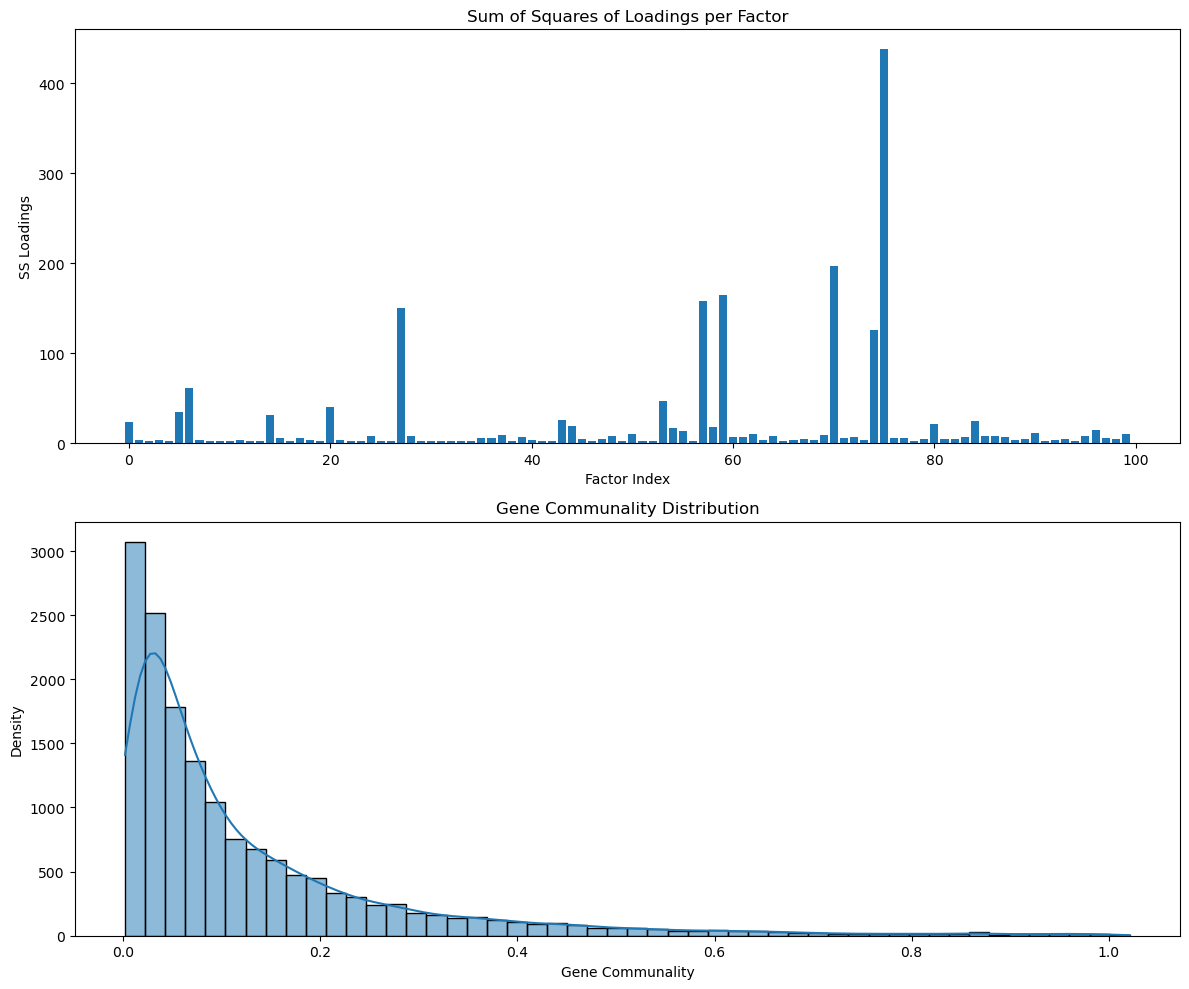

In [3]:
# Cell 2 — Diagnostic plots: SS by factor and gene communality
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
axes[0].bar(range(len(adata.uns["fa"]["ss_loadings_per_factor"])),
            adata.uns["fa"]["ss_loadings_per_factor"])
axes[0].set_title("Sum of Squares of Loadings per Factor")
axes[0].set_xlabel("Factor Index")
axes[0].set_ylabel("SS Loadings")

sns.histplot(adata.var["communality"], ax=axes[1], bins=50, kde=True)
axes[1].set_title("Gene Communality Distribution")
axes[1].set_xlabel("Gene Communality")
axes[1].set_ylabel("Density")
plt.tight_layout()
plt.show()

In [4]:
# Cell 3 — Sanity checks (no reloads)
ss_per_factor = adata.uns["fa"]["ss_loadings_per_factor"]
communality = adata.var["communality"].to_numpy()
print("sum SS factors:", float(ss_per_factor.sum()))
print("sum communalities:", float(communality.sum()))
frac = ss_per_factor / ss_per_factor.sum()
print("Top-10 factors’ SS fraction:", float(np.sort(frac)[-10:].sum()))
R = np.corrcoef(Z, rowvar=False)
off_diag_max = np.max(np.abs(R - np.eye(Z.shape[1])))
print("Max |corr(Z) off-diagonal|:", float(off_diag_max))

sum SS factors: 1994.9719568886478
sum communalities: 1994.9719568886458
Top-10 factors’ SS fraction: 0.7100605591528054
Max |corr(Z) off-diagonal|: 0.058912959616634834


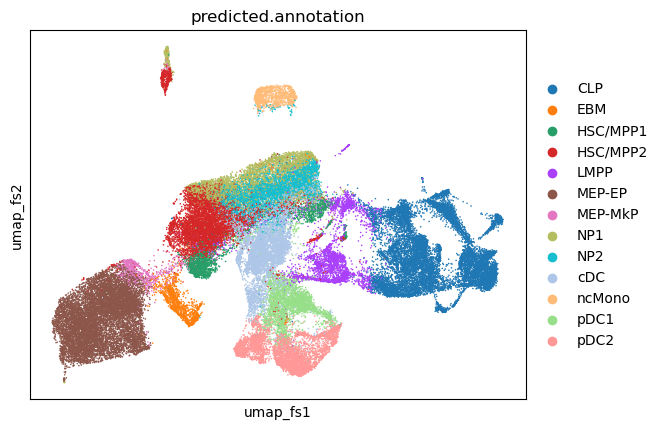

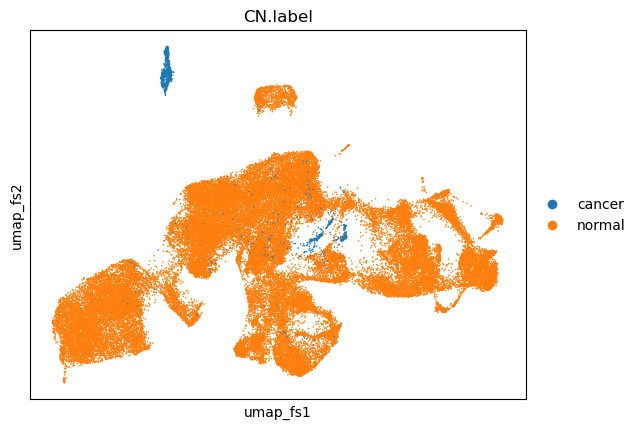

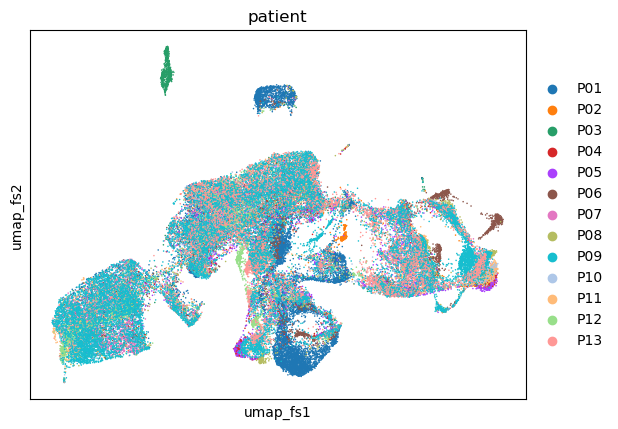

In [5]:
# Cell 4 — Neighbors + UMAP using FA representation
rep = "fs_t_scores" if "fs_t_scores" in adata.obsm else "fs_scores"
X = adata.obsm[rep]
if rep != "fs_t_scores":
    X = (X - X.mean(axis=0)) / (X.std(axis=0, ddof=1) + 1e-9)
adata.obsm["X_fs"] = X.astype(np.float32)

sc.pp.neighbors(adata, use_rep="X_fs", n_neighbors=30, metric="euclidean", key_added="fs")
sc.tl.umap(adata, neighbors_key="fs", min_dist=0.3, random_state=0, key_added="umap_fs")

sc.pl.embedding(adata, basis="umap_fs", color=["predicted.annotation"],
                legend_loc="right margin", wspace=0.35, size=5)
sc.pl.embedding(adata, basis="umap_fs", color=["CN.label"],
                legend_loc="right margin", wspace=0.35, size=5)
sc.pl.embedding(adata, basis="umap_fs", color=["patient"],
                legend_loc="right margin", wspace=0.35, size=5)

In [6]:
# Cell 5 — Factor–label association (η²) using the same FA representation
def eta2_per_factor(Zmat, labels):
    cat = pd.Categorical(labels)
    codes = cat.codes
    valid = codes >= 0
    Zmat = np.asarray(Zmat)[valid]
    codes = codes[valid]
    n_groups = len(cat.categories)
    k = Zmat.shape[1]
    eta2 = np.empty(k, dtype=float)
    counts = np.bincount(codes, minlength=n_groups)
    for j in range(k):
        y = Zmat[:, j]
        gm = y.mean()
        ss_total = np.sum((y - gm) ** 2)
        if ss_total <= 0:
            eta2[j] = np.nan
            continue
        sums = np.bincount(codes, weights=y, minlength=n_groups)
        means = np.divide(sums, counts, out=np.zeros_like(sums), where=counts > 0)
        ss_between = np.sum(counts * (means - gm) ** 2)
        eta2[j] = ss_between / ss_total
    return pd.Series(eta2, name="eta2").sort_values(ascending=False)

Z_for_assoc = adata.obsm["X_fs"]
eta_pred = eta2_per_factor(Z_for_assoc, adata.obs["predicted.annotation"])
eta_cn = eta2_per_factor(Z_for_assoc, adata.obs["CN.label"])
eta_patient = eta2_per_factor(Z_for_assoc, adata.obs["patient"])
print("Top η² (predicted.annotation):"); print(eta_pred.head(10))

Top η² (predicted.annotation):
27    0.853218
53    0.792338
57    0.769837
0     0.732596
6     0.717614
70    0.670934
20    0.631259
62    0.423184
14    0.408583
28    0.325435
Name: eta2, dtype: float64


In [7]:
# Cell 6 — Fit diagnostics using this same AnnData (reconstruction and residuals)
X_data = adata.X.A if hasattr(adata.X, "A") else adata.X
X_data = np.asarray(X_data, dtype=np.float32)

Xhat = mu + Z @ L.T
res = X_data - Xhat
res_var = res.var(axis=0, ddof=1)

corr = np.corrcoef(res_var, psi)[0, 1]
print("Corr(residual variance, psi):", float(corr))

x_var = X_data.var(axis=0, ddof=1)
r2_gene = 1.0 - (res_var / (x_var + 1e-12))
print("Median gene R^2:", float(np.median(r2_gene)))

Corr(residual variance, psi): 0.999762334064229
Median gene R^2: 0.06700733473522247
